<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#quick-start" data-toc-modified-id="quick-start-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>quick start</a></span><ul class="toc-item"><li><span><a href="#Resources" data-toc-modified-id="Resources-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Resources</a></span></li></ul></li><li><span><a href="#FULL-MODEL" data-toc-modified-id="FULL-MODEL-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>FULL MODEL</a></span><ul class="toc-item"><li><span><a href="#Packages" data-toc-modified-id="Packages-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Packages</a></span><ul class="toc-item"><li><span><a href="#Qnetwork" data-toc-modified-id="Qnetwork-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Qnetwork</a></span></li></ul></li><li><span><a href="#POMDP-RNN-Game" data-toc-modified-id="POMDP-RNN-Game-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>POMDP RNN Game</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Standard-setting：-grid-=--(3,7)，-holes-=-0" data-toc-modified-id="Standard-setting：-grid-=--(3,7)，-holes-=-0-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Standard setting： grid =  (3,7)， holes = 0</a></span></li><li><span><a href="#Model-Tranining" data-toc-modified-id="Model-Tranining-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Model Tranining</a></span></li><li><span><a href="#decoding-vs-performance" data-toc-modified-id="decoding-vs-performance-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>decoding vs performance</a></span></li><li><span><a href="#learning-rate-vs-performance" data-toc-modified-id="learning-rate-vs-performance-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>learning rate vs performance</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-2.3.5"><span class="toc-item-num">2.3.5&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why" data-toc-modified-id="Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why-2.3.6"><span class="toc-item-num">2.3.6&nbsp;&nbsp;</span>Anlytic part , check the behaviour correspond to each decoding level and explain why</a></span></li></ul></li><li><span><a href="#PCA" data-toc-modified-id="PCA-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>PCA</a></span></li></ul></li></ul></div>

# quick start 

The dynamics is shown to be line atttractors.  But how this attractor is used?  What is relation between them and real game dynamics?  

## Resources

* [*The* Reinforcement learning book from Sutton & Barto](http://incompleteideas.net/sutton/book/the-book-2nd.html)
* [The REINFORCE paper from Ronald J. Williams (1992)](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)


# FULL MODEL

## Packages

In [10]:
%load_ext autoreload
%autoreload 2

import numpy as np
from itertools import count
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.nn import init
from torch.nn import DataParallel
from torch.utils.data import DataLoader

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.animation
import seaborn as sns
from IPython.display import HTML

import pretrain
from pretrain import *

import pandas as pd

import navigation2
from navigation2 import *

import sklearn
from sklearn.svm import SVC

import scipy
from scipy.spatial import distance
from scipy import signal

import Nets 
from Nets import *

import dynamics
from dynamics import * 

import GLM
from GLM import *

from mpl_toolkits.mplot3d import Axes3D  

%pylab inline
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


3 condition for ending , when pass time limit, game over

For weight update, it seems to be better do it after episode, as it makes non-sense evaluate strategy during episode, but a the end. Also, it is much quicker. 

A programming of MDP here, hidden state is as state of enviroment

Training from zero seems to be better because it will allow the agent to explore from new

**A coherent result here is threhold kind behaviour of decode vs performance, after decode smaller than 10, the performance rises.  The resutls is showeing that the learning rate vs performance doesn't characterize the threshold kind behaviour of performance change.  It is only after lr = -5, the performance begins to rise , while the learning rate - performance curve creates a fake trends for first few points.  This is not shown by explaination factor calculated by covariance.  **

### Pretrained network
Record the relaxation to line attractor by setting on the averaged action for different steps(T=2 for initially, T=100 for more.

How much variance is caused action, how much is caused by action itself? 

Measure velocity with null actions and with full actions, compare the velocity caused by action and remaing velocity,  it might reveals the dh/dt = ah + bA with a and b measured.   

If with null action speed not goes to 0, think how the given dynamical structures gives the position components, does it still effective to say that with action is fast direction, null action is slow direction

In [15]:
class slowmanifold():
    def __init__(self, weight):
        self.weight = weight
        self.pca = PCA(weight, size = 15)
        
    def Simulations(self, k_action = 1, epsilon = 0, size = 15, T = 200, seed_num = 1e3, reward_control = None):
        PC_traces = []
        Hiddens = []
        Poss = []
        Actions = []
        States = []
        Context = []
        for i in range(T):
            torch.manual_seed(np.random.randint(seed_num))
            hidden0 = torch.randn(1, 512)
            if reward_control == None:
                c  = np.random.randint(2)
            else:
                c = reward_control
            start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
            game = ValueMaxGame(grid_size = (size, size), holes = 0, random_seed = 0 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, discount = 0.9, alpha = 1
                               ,lam = 0)
            game.net.load_state_dict(torch.load(self.weight))
            game.net.k_action = k_action 
            grid = game.grid.grid.copy()
            Pos, hidden, dh, Action, State, reward = trajectory(game, start, reward_control = c, size = size, \
                                                                      test = 0, limit_set = 4, init_hidden = False, hidden = hidden0, epsilon = epsilon)
            Hiddens.append(hidden)
            Poss.append(Pos[1:])
            Actions.append(Action)
            States.append(State)
            Context.append(c * np.ones(len(State)))
        return States, Poss, Hiddens, Actions, Context   
    
    def Transform(self, States, Poss, Hiddens, Actions, Context, history = False, size = 15):
    # last click state
        Status = np.concatenate([State_transform(state, poss, size) for state, poss in zip(States, Poss)])
        Hiddens = np.concatenate(Hiddens)
        Poss = np.concatenate(Poss)
        Actions = np.concatenate(Actions)
        Context = np.concatenate(Context)
        # transform state to stim　
        States = np.concatenate(States)
        # transform status to memory
        Memory = history_summary(Status)
        set_ = set([tuple(s) for s in States])
        dict_ = {}
        for i, s in enumerate(set_): 
            dict_.update({s:i})
        Stim = [dict_[tuple(s)] for s in States] 
        set_ = set([tuple(m) for m in Memory])
    #     dict_ = {}
    #     for i, m in enumerate(set_): 
    #         dict_.update({m:i})
    #     Mem = [dict_[tuple(m)] for m in Memory] 
        if history == False:
            return States, Poss, Hiddens, Actions, Status, Context
        else:
            return States, Poss, Hiddens, Actions, Status, Context, Memory 
        
    def pca_record(self):
        self.pca.pca(T_duration = 5)
        
    def data_record(self, epsilon = 0.5, T = 500):
        States, Poss, Hiddens, Actions, Context = self.Simulations(k_action = 1, epsilon = epsilon, size = 15, T = T, seed_num = 1e3, reward_control = 0)
        States, Poss, Hiddens, Actions, Status, Context, Memory = self.Transform(States, Poss, Hiddens, Actions, Context, history = True, size = 15)
        self.States = States
        self.Poss = Poss
        self.Hiddens = Hiddens
        self.Actions = Actions
        self.Status = Status
        self.Context = Context
        self.Memory = Memory 
        
    def manifold_record(self, T_slow = 5):
#         Hiddens0 = self.Hiddens[self.Status == status]
        Hidden1 = []
        Velocity0 = []
        Velocity1 = []
        Pos_r = [(9, 5), (9, 13)]
        for hidden0, c, a in zip(self.Hiddens, self.Context, self.Actions):
            context = self.pca.game.placefield(Pos_r[int(c)])
            hidden0 = torch.from_numpy(hidden0).type(torch.FloatTensor)
            velocity0 = fixpoints(self.weight, hidden0, stim = torch.zeros(1, 9), action = a)
            Velocity0.append(velocity0)
            hidden0 = self.pca.relaxation(T = T_slow, hidden0 = hidden0, context = context)
            velocity = fixpoints(self.weight, hidden0, stim = torch.zeros(1, 9), action = 4)
            Velocity1.append(velocity)
            Hidden1.append(hidden0)
        Hidden1 = np.array(Hidden1)
        return Hidden1, Velocity0, Velocity1
    
    def gradientdescent(self, hidden0, stim = torch.zeros(1, 9) , action = 4, iterations = 1):
        for i in range(int(iterations * 1e2)+1):
            hidden0 = Variable(hidden0,requires_grad=True)
            velocity = fixpoints(weight, hidden0, stim = stim, action = action)
            if i%500 == 0:
                print (i, velocity)
        #     print (hidden0.requires_grad)
            velocity.backward()
        #     print ('grad0', hidden0.grad[0][0])
            hidden0 = torch.add(hidden0, -1e-2 * (hidden0.grad))
            hidden0 = Variable(hidden0,requires_grad=True)
        return hidden0, velocity
    
    def manifold_record_2(self, T_slow = 100):
#         Hiddens0 = self.Hiddens[self.Status == status]
        Hidden1 = []
        Velocity0 = []
        Velocity1 = []
        Pos_r = [(9, 5), (9, 13)]
        for hidden0, c, a in zip(self.Hiddens, self.Context, self.Actions):
            context = self.pca.game.placefield(Pos_r[int(c)])
            hidden0 = torch.from_numpy(hidden0).type(torch.FloatTensor)
            velocity0 = fixpoints(self.weight, hidden0, stim = torch.zeros(1, 9), action = a)
            Velocity0.append(velocity0)
            hidden0 = self.pca.relaxation(T = 2, hidden0 = hidden0, context = context)
            velocity = fixpoints(self.weight, hidden0, stim = torch.zeros(1, 9), action = 4)
            Velocity1.append(velocity)
            Hidden1.append(hidden0)
        Hidden100 = []
        Velocity100 = []
        Pos_r = [(9, 5), (9, 13)]
        for hidden0, c in zip(self.Hiddens, self.Context):
            context = self.pca.game.placefield(Pos_r[int(c)])
            hidden0 = torch.from_numpy(hidden0).type(torch.FloatTensor)
            hidden0 = self.pca.relaxation(T = T_slow, hidden0 = hidden0, context = context)
            velocity = fixpoints(self.weight, hidden0, stim = torch.zeros(1, 9), action = 4)
            Velocity100.append(velocity)
            Hidden100.append(hidden0)
        Hidden1 = np.array(Hidden1)
        Hidden100 = np.array(Hidden100)
        return Hidden1, Hidden100, Velocity0, Velocity1, Velocity100
    

### Starting from random 

**color the slow manifold by stimulus memory and position, if the ring-like manifold corresponding to any structure**

## MemNet 

# PosNet

# color the state space according to memory state, past history
Until now it seems the hidden states only record single history of last stimlus, which is reflected in line attractor behavoiur, which in constrast to claim of 2 clicks

In [16]:
weight = 'weights_mem/rnn_1515tanh512_checkpoint{}'.format(49)
# Pretest = PretrainTest(weight, holes = 0, inputs_type = (1, 0), size = 15)
# Pretest.loadweight(weight)
manifold = slowmanifold(weight)
manifold.pca_record()
manifold.data_record(epsilon = 0.2,  T = 100)
Hidden1, Velocity0, Velocity1 = manifold.manifold_record(T_slow = 10)
Hidden2, Velocity0, Velocity2 = manifold.manifold_record(T_slow = 50)

# Hidden2 = []
# for r in np.arange(5):
#     h = Hidden1[manifold.Status == r][0]
#     h1 = manifold.gradientdescent(h, iterations=10)
#     Hidden2.append(h1)

colors = ['k', 'r', 'g', 'b', 'c']

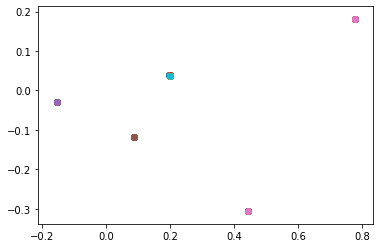

In [17]:
for i in range(len(Hidden1)):
    plt.scatter(Hidden2[i].data.numpy() @ manifold.pca.vect[0],\
                Hidden2[i].data.numpy() @ manifold.pca.vect[1])
#     print (Hidden2[i].data.numpy() @ manifold.pca.vect[0]/Hidden2[i].data.numpy() @ manifold.pca.vect[1])

In [153]:
manifold.Memory

array([[0., 0.],
       [4., 0.],
       [4., 0.],
       ...,
       [1., 4.],
       [1., 4.],
       [1., 4.]])

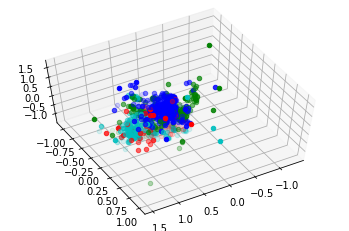

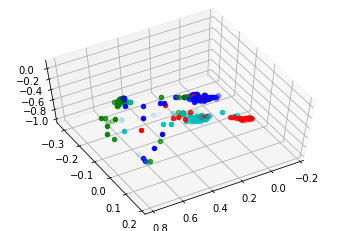

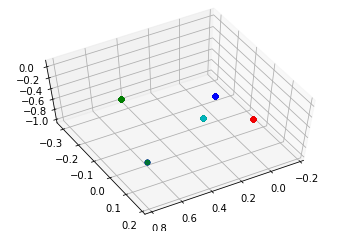

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for k in [1, 2, 3, 4]:
    V = np.array(Velocity0)[manifold.Status == k]
    V = [v.data.numpy().item() for v in V]
    
    for i, hidden in enumerate(manifold.Hiddens[manifold.Status == k]):
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1],
                   hidden @ manifold.pca.vect[2], color = colors[k], alpha = (V[i]/np.max(V))**2)
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for k in [1, 2, 3, 4]:
    V = np.array(Velocity0)[manifold.Status == k]
    V = [v.data.numpy().item() for v in V]
    
    for i, hidden in enumerate(Hidden1[manifold.Status == k]):
        ax.view_init(60, 60)
        ax.scatter(hidden[0].data.numpy() @ manifold.pca.vect[0], hidden[0].data.numpy() @ manifold.pca.vect[1],
                   hidden[0].data.numpy() @ manifold.pca.vect[2], color = colors[k], alpha = (V[i]/np.max(V))**2)
#         ax.scatter(Hidden1[manifold.Status == k][0].data.numpy() @ manifold.pca.vect[0], Hidden1[manifold.Status == k][0].data.numpy() @ manifold.pca.vect[1],
#                    Hidden1[manifold.Status == k][0].data.numpy() @ manifold.pca.vect[2], color = colors[k], alpha = 1, marker = 's', s = 80)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for k in [1, 2, 3, 4]:
    V = np.array(Velocity0)[manifold.Status == k]
    V = [v.data.numpy().item() for v in V]
    
    for i, hidden in enumerate(Hidden2[manifold.Status == k]):
        ax.view_init(60, 60)
        ax.scatter(hidden[0].data.numpy() @ manifold.pca.vect[0], hidden[0].data.numpy() @ manifold.pca.vect[1],
                   hidden[0].data.numpy() @ manifold.pca.vect[2], color = colors[k], alpha = (V[i]/np.max(V))**2)

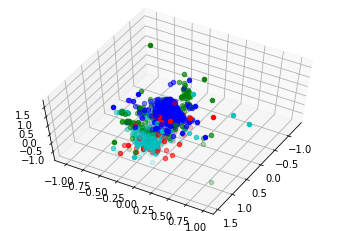

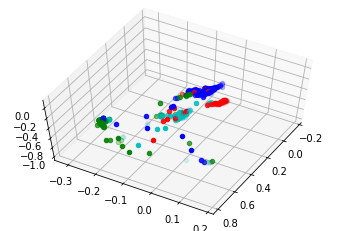

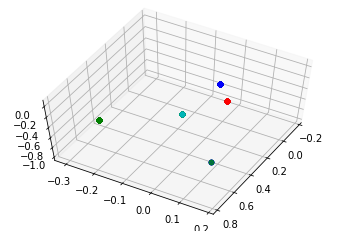

In [19]:
Memory1 = np.array([m[0] for m in manifold.Memory])
Memory2 = np.array([m[1] for m in manifold.Memory])



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for k in [1, 2, 3, 4]:
    V = np.array(Velocity0)[Memory1 == k]
    V = [v.data.numpy().item() for v in V]
    
    for i, hidden in enumerate(manifold.Hiddens[Memory1 == k]):
        ax.view_init(60, 30)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1],
                   hidden @ manifold.pca.vect[2], color = colors[k], alpha = (V[i]/np.max(V))**2)
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for k in [1, 2, 3, 4]:
    V = np.array(Velocity0)[Memory1 == k]
    V = [v.data.numpy().item() for v in V]
    
    for i, hidden in enumerate(Hidden1[Memory1 == k]):
        ax.view_init(60, 30)
        ax.scatter(hidden[0].data.numpy() @ manifold.pca.vect[0], hidden[0].data.numpy() @ manifold.pca.vect[1],
                   hidden[0].data.numpy() @ manifold.pca.vect[2], color = colors[k], alpha = (V[i]/np.max(V))**2)
#         ax.scatter(Hidden1[manifold.Status == k][0].data.numpy() @ manifold.pca.vect[0], Hidden1[manifold.Status == k][0].data.numpy() @ manifold.pca.vect[1],
#                    Hidden1[manifold.Status == k][0].data.numpy() @ manifold.pca.vect[2], color = colors[k], alpha = 1, marker = 's', s = 80)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for k in [1, 2, 3, 4]:
    V = np.array(Velocity0)[Memory1 == k]
    V = [v.data.numpy().item() for v in V]
    for i, hidden in enumerate(Hidden2[Memory1 == k]):
        ax.view_init(60, 30)
        ax.scatter(hidden[0].data.numpy() @ manifold.pca.vect[0], hidden[0].data.numpy() @ manifold.pca.vect[1],
                   hidden[0].data.numpy() @ manifold.pca.vect[2], color = colors[k], alpha = (V[i]/np.max(V))**2)

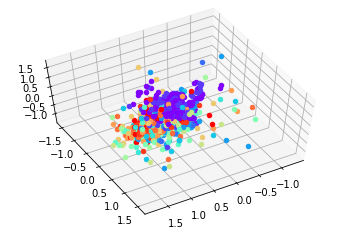

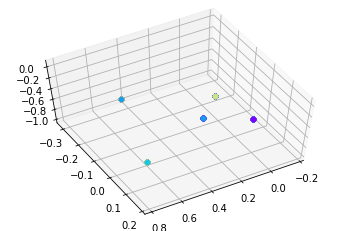

In [20]:
Y = [poss[0] for poss in manifold.Poss]
X = [poss[1] for poss in manifold.Poss]
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(X))))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(manifold.Hiddens[X == x]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(Hidden2[X == x]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden[0].data.numpy() @ manifold.pca.vect[0], hidden[0].data.numpy() @ manifold.pca.vect[1], hidden[0].data.numpy() @ manifold.pca.vect[2], color = c, label = x)
#         plt.legend()

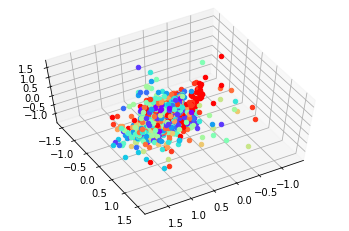

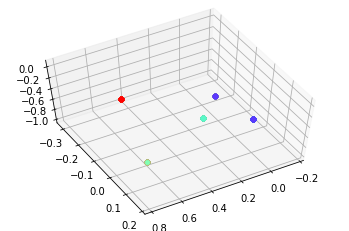

In [21]:
Y = [poss[0] for poss in manifold.Poss]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(Y))))
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(manifold.Hiddens[Y == y]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c)

        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(Hidden2[Y == y]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden[0].data.numpy() @ manifold.pca.vect[0], hidden[0].data.numpy() @ manifold.pca.vect[1], hidden[0].data.numpy() @ manifold.pca.vect[2], color = c)

## Input statistics is very important, keep the action noise small will better reveal the internal structure dynamics.  Now the question is what is relation from ring to position it is not clear, it is more like the ring is segmented by the wall not pos

In [27]:
weight = 'weights_basic_mem/rnn_1515tanh512_checkpoint{}_{}_{}'.format(49, 0, 9)
Pretest = PretrainTest(weight, holes = 0, inputs_type = (1, 0), size = 15)
Pretest.loadweight(weight)
manifold2 = slowmanifold(weight)
manifold2.pca_record()
manifold2.data_record(epsilon = 0.0, T = 1)
Hidden1, Velocity0, Velocity1 = manifold2.manifold_record(T_slow = 10)
       

In [28]:
manifold2.Status 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 4, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4])

45 44


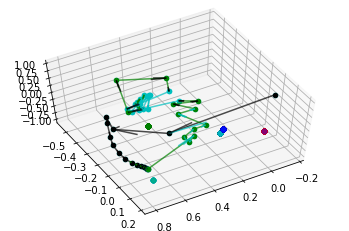

In [29]:
colors = ['k', 'r', 'g', 'b', 'c']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X = []
Y = []
Z = []
Colors = []
for i, hidden in enumerate(manifold2.Hiddens):
    ax.view_init(60, 60)
    ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1],
               hidden @ manifold.pca.vect[2], color = colors[k])
    X.append(hidden @ manifold.pca.vect[0])
    Y.append(hidden @ manifold.pca.vect[1])
    Z.append(hidden @ manifold.pca.vect[2])
    Colors.append(colors[manifold2.Status[i]])
    ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2],\
              color = colors[manifold2.Status[i]])
X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)
U = X[1:] - X[:-1]
V = Y[1:] - Y[:-1]
W = Z[1:] - Z[:-1]
print (len(Z), len(W))
ax.quiver(X[:-1], Y[:-1], Z[:-1], U, V, W,  color = Colors, alpha = 0.7)
for k in [1, 2, 3, 4]:
#     V = np.array(Velocity0)[manifold.Status == k]
#     V = [v.data.numpy().item() for v in V]
    
    for i, hidden in enumerate(Hidden2[manifold.Status == k]):
        ax.scatter(hidden[0].data.numpy() @ manifold.pca.vect[0], hidden[0].data.numpy() @ manifold.pca.vect[1],
                   hidden[0].data.numpy() @ manifold.pca.vect[2], color = colors[k], alpha = 0.2)
plt.savefig('dynamics', dpi = 400)    

**The real game falls into the first one and two PCs quickly after cliking into the wall, means that the PC3 is a fast dimension and the other twos are slow manifold,  which we could define a plane**

34 33
46 45
46 45


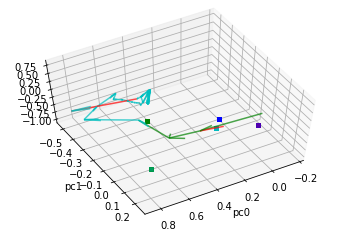

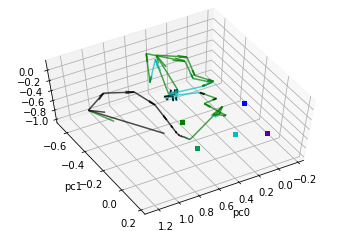

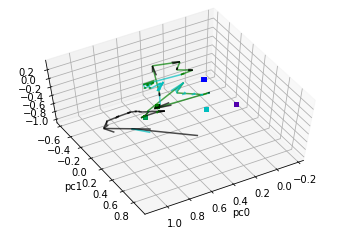

In [36]:
colors = ['k', 'r', 'g', 'b', 'c']


weight = 'weights_basic_mem/rnn_1515tanh512_checkpoint{}_{}_{}'.format(49, 0, 9)
for K in range(3):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    manifold2 = slowmanifold(weight)
    manifold2.pca_record()
    manifold2.data_record(epsilon = 0.0, T = 1)
    X = []
    Y = []
    Z = []
    Colors = []
    Hidden1, Velocity0, Velocity1 = manifold2.manifold_record(T_slow = 10)
    for i, hidden in enumerate(manifold2.Hiddens):
        ax.view_init(60, 60)
#         ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1],
#                    hidden @ manifold.pca.vect[2], color = colors[k])
        X.append(hidden @ manifold.pca.vect[0])
        Y.append(hidden @ manifold.pca.vect[1])
        Z.append(hidden @ manifold.pca.vect[2])
        Colors.append(colors[manifold2.Status[i]])
#         ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2],\
#                   color = colors[manifold2.Status[i]])
    X = np.array(X)
    Y = np.array(Y)
    Z = np.array(Z)
    U = X[1:] - X[:-1]
    V = Y[1:] - Y[:-1]
    W = Z[1:] - Z[:-1]
    print (len(Z), len(W))
    ax.quiver(X[:-1], Y[:-1], Z[:-1], U, V, W,  color = Colors, alpha = 0.7)
    for k in [1, 2, 3, 4]:
        for i, hidden in enumerate(Hidden2[manifold.Status == k]):
            ax.scatter(hidden[0].data.numpy() @ manifold.pca.vect[0], hidden[0].data.numpy() @ manifold.pca.vect[1],
                       hidden[0].data.numpy() @ manifold.pca.vect[2], color = colors[k], alpha = 0.5, marker = 's')
    plt.xlabel('pc0')
    plt.ylabel('pc1')
    plt.savefig('dynamics_mem{}'.format(K), dpi = 400)    

46 45
34 33
42 41


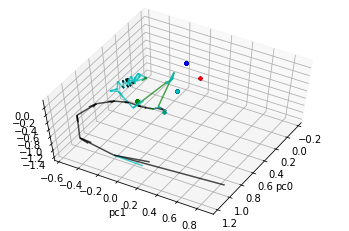

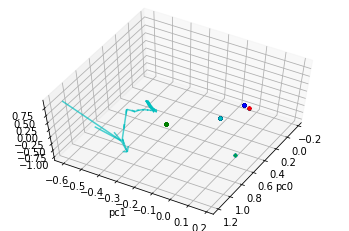

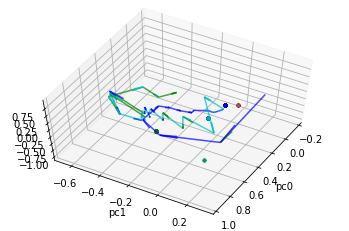

In [37]:
colors = ['k', 'r', 'g', 'b', 'c']


weight = 'weights_basic_mem/rnn_1515tanh512_checkpoint{}_{}_{}'.format(49, 0, 9)
for K in range(3):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    manifold2 = slowmanifold(weight)
    manifold2.pca_record()
    manifold2.data_record(epsilon = 0.1, T = 1)
    X = []
    Y = []
    Z = []
    Colors = []
    Hidden1, Velocity0, Velocity1 = manifold2.manifold_record(T_slow = 10)
    for i, hidden in enumerate(manifold2.Hiddens):
        ax.view_init(60, 30)
#         ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1],
#                    hidden @ manifold.pca.vect[2], color = colors[k])
        X.append(hidden @ manifold.pca.vect[0])
        Y.append(hidden @ manifold.pca.vect[1])
        Z.append(hidden @ manifold.pca.vect[2])
        Colors.append(colors[manifold2.Status[i]])
#         ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2],\
#                   color = colors[manifold2.Status[i]])
    X = np.array(X)
    Y = np.array(Y)
    Z = np.array(Z)
    U = X[1:] - X[:-1]
    V = Y[1:] - Y[:-1]
    W = Z[1:] - Z[:-1]
    print (len(Z), len(W))
    ax.quiver(X[:-1], Y[:-1], Z[:-1], U, V, W,  color = Colors, alpha = 0.7)
    for k in [1, 2, 3, 4]:
        for i, hidden in enumerate(Hidden2[manifold.Status == k]):
            ax.scatter(hidden[0].data.numpy() @ manifold.pca.vect[0], hidden[0].data.numpy() @ manifold.pca.vect[1],
                       hidden[0].data.numpy() @ manifold.pca.vect[2], color = colors[k], alpha = 0.5, marker = '.')
    plt.xlabel('pc0')
    plt.ylabel('pc1')
    plt.savefig('dynamics_mem{}'.format(3+K), dpi = 400)    

In [254]:
Y = [poss[0] for poss in manifold.Poss]
X = [poss[1] for poss in manifold.Poss]
np.unique(Y)

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

### Summary

**0 The strategy is directly reflecting the internal dynamics**

**1 The ability to model the external world lies in richness of internal dynamics, for example the distribution of timescales forms during the pretraining**

**2 To characterize the rich internal timescales , there are 5 features, 1,  the ratio limit cycle/fix point 2,  the mean of relaxation time to fix point 3, the variance of relaxation timescale to fix point  4, the distribution of timescales of limit cycles 5,  The multi-stablity from stimulus**

**3 The performance are : extrapolation performance(small, large),  intrapolation performance(small , middle , large),  learning speed, learning stability,  Try to to connect the 5 features of dynamics to the performance metrix**

**4, Until now ratio limit cycle/fix point during the close loop form seems to indicates best the performance but with noise.**  


**what is the relation between close loop and open loop analysis?**

longer time, there is no pheonmean associate with multi-stability

Here with action feedback, dynamics shift to a totally different regime which is around hopf bifurcation, but it is not hugely shaped by the stimulus

From this graph of PC, we will see that the representation states of trajectory (3,5) and (14,5) are actually qutie close to each other , reflecting symmetry in real space, it is in spirit of predictive decoding, using least number of interal states to play well. 

# Conclusion
**Internal dynamics rather than decoding performance influences more the performance in uncertain enviroments**

**Consider to think in global loops rather than separated system, thus the coupled dynamical system.  This system, which has its genome on its internal weights, will have quite different different pheno-types from the global loops,  richness of internal dynamics turns into extenable phenotypes which supports behaviours across scales.   The different types of attractors, fix point, limit cycle becomes substrate of strategy in different size rooms.  Thus generalization can be done until certain size, which offers complicate behaviour with a "simple mind"**

**The triangle between decoding, dynamics and navigation should be like: 1, dynamics coded by internal weight is most fundamental, it gives rise to different representations(phenotypes).   2,  The relation between decoding and navigation are reciprocal. not random behaviour gives better enviromental prediction(complement the free energy principle) 2,  we should distinguish internal dynamics and global dynamics**